In [2]:
#Importation des librairies nécessaires 

import numpy as np
import pandas as pd
import datetime as dt 
import yfinance as yf 
import matplotlib.pyplot as plt
from scipy.stats import norm

In [6]:
# Réglage d'une plage de temps pour un certain nombre d'années

années = 15

datefin = dt.datetime.now()

datedébut = datefin - dt.timedelta(days = 365 * années)

In [5]:
# Création d'une liste de tickers 

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [12]:
# Cours de clôture ajustés quotidiennement pour les tickers  ( ajustés car ils prennent en compte les dividendes et stock splits)

cloture_aj_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = datedébut, end = datefin)
    cloture_aj_df[ticker] = data['Adj Close']

    
print(cloture_aj_df)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2008-10-20   73.948654  47.656452   78.500000   29.041935   36.919704
2008-10-21   71.740860  48.471031   76.029999   27.537357   35.804356
2008-10-22   67.834267  48.690895   71.709999   26.776316   33.807281
2008-10-23   68.620102  48.464626   70.650002   26.671347   34.229290
2008-10-24   65.140083  47.908562   72.209999   25.814081   32.586407
...                ...        ...         ...         ...         ...
2023-10-09  432.290009  69.480003  172.820007  366.559998  214.300003
2023-10-10  434.540009  6

In [13]:
# calcul des rendements journaliers en log  et suppression de tous les NA

rendements_log  = np.log(cloture_aj_df/ cloture_aj_df.shift(1))
rendements_log  = rendements_log.dropna()

print(rendements_log)


                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2008-10-21 -0.030311  0.016948 -0.031971 -0.053197 -0.030676
2008-10-22 -0.055993  0.004526 -0.058498 -0.028026 -0.057393
2008-10-23  0.011518 -0.004658 -0.014892 -0.003928  0.012406
2008-10-24 -0.052045 -0.011540  0.021840 -0.032670 -0.049186
2008-10-27 -0.036147 -0.005412 -0.000416 -0.028180 -0.032913
...              ...       ...       ...       ...       ...
2023-10-09  0.006382  0.010126  0.018218  0.005087  0.006273
2023-10-10  0.005191 -0.001008 -0.001680  0.005523  0.006187
2023-10-11  0.004088  0.004600  0.007277  0.007110  0.003934
2023-10-12 -0.006115 -0.008642 -0.003054 -0.003481 -0.008070
2023-10-13 -0.004993  0.004618  0.031642 -0.012650 -0.005651

[3771 rows x 5 columns]


In [14]:
# Création d'un portefeuille équipondéré

valeur_portefeuille = 1000000
poids = np.array([1/len(tickers)] * len(tickers))
print(poids)

[0.2 0.2 0.2 0.2 0.2]


In [15]:
# Calcul des rendements historiques du portefeuille

rendements_historiques = (rendements_log * poids).sum(axis = 1)
print(rendements_historiques)

Date
2008-10-21   -0.025841
2008-10-22   -0.039077
2008-10-23    0.000089
2008-10-24   -0.024720
2008-10-27   -0.020614
                ...   
2023-10-09    0.009217
2023-10-10    0.002843
2023-10-11    0.005402
2023-10-12   -0.005873
2023-10-13    0.002593
Length: 3771, dtype: float64


In [17]:
# On retrouve les rendements historiques du jour X

jours = 5

range_rendements = rendements_historiques.rolling(window = jours).sum()
range_rendements = range_rendements.dropna()
print(range_rendements)



Date
2008-10-27   -0.110163
2008-10-28   -0.019267
2008-10-29    0.017856
2008-10-30    0.032924
2008-10-31    0.059499
                ...   
2023-10-09    0.012036
2023-10-10    0.026246
2023-10-11    0.024769
2023-10-12    0.019889
2023-10-13    0.014182
Length: 3767, dtype: float64


In [19]:
# Spécifiction d'un intervalle de confiance et calcul la VaR par méthode historique

intervalle_confiance = 0.95

VaR_hist = -np.percentile(range_rendements, 100 - (intervalle_confiance * 100)) * valeur_portefeuille

print(VaR_hist)



25727.143257926957


## Sur une période de cinq jours, avec un niveau de confiance de 95%, la perte maximale potentielle est d'environ 25 728 dollars sur notre portefeuillle.

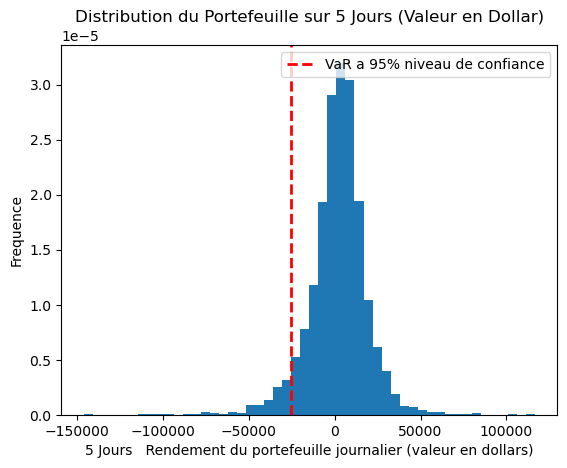

In [36]:
#Plot des résultats des rendements historiques et de la VaR estimée

fenetre_rendements = jours
range_rendements = rendements_historiques.rolling(window = fenetre_rendements).sum()
range_rendements = range_rendements.dropna()

range_rendements_dollar = range_rendements * valeur_portefeuille

plt.hist(range_rendements_dollar.dropna(), bins = 50, density = True)
plt.xlabel(f'{fenetre_rendements} Jours   Rendement du portefeuille journalier (valeur en dollars)')
plt.ylabel('Frequence')
plt.title(f'Distribution du Portefeuille sur {fenetre_rendements} Jours (Valeur en Dollar)')
plt.axvline(-VaR_hist, color='r',linestyle='dashed', linewidth=2, label=f'VaR a {intervalle_confiance:.0%} niveau de confiance')
plt.legend()
plt.show()

